## Financial Market Analytics Project

In [3]:
# All imports
import pandas as pd
import numpy as np
from scipy.stats import skew
from datetime import datetime, timedelta
import plotly.express as px
import plotly.io as pio
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import cvxpy as cp



### Load data

In this section our dataset is loaded  into a Pandas Dataframe to allow easier and more efficient annalysis. We opted for the S&P500 dataset as it is not only the most widely followed equity index in the world, but it represents approximately 80% of the U.S. market capitalization as well, which in turn dominates global equity markets.

In [4]:
# Read the data, skipping the first row and using the second row as headers
df_sp_m_new = pd.read_excel("../Datasets/SPX500.xlsx", sheet_name="Price", engine="openpyxl", skiprows=[0], header=0)

df_sp_d_new = pd.read_excel("../Datasets/SPX500.xlsx", sheet_name="Price daily", engine="openpyxl", skiprows=[0], header=0)

# Flatten the MultiIndex columns created by read_excel with header=0 and skiprows=[0]
df_sp_m_new.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_sp_m_new.columns]
df_sp_d_new.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_sp_d_new.columns]

print("New df_sp_m head:")
display(df_sp_m_new.head())

New df_sp_m head:


,data,3M Co,Abbott Laboratories,ACME-Cleveland Corp,Advanced Micro Devices Inc,AEP Texas Inc,Aeroquip-Vickers Inc,AIG Life Holdings Inc,Air Products & Chemicals Inc,Alberto-Culver Co,...,Cboe Global Markets Inc.1,United Continental Holdings Inc.1,WellCare Health Plans Inc,Advanced Micro Devices Inc.2,Fortinet Inc,Linde PLC,Rollins Inc,Jack Henry & Associates Inc,Keysight Technologies Inc,Regency Centers Corp.1
0,1990-12-31,20.629,5.0348,4.750,2.4375,22.0000,18.250,7.6875,12.6542,9.5408,...,NaN,NaN,NaN,NaN,NaN,NaN,1.2437,0.1250,NaN,NaN
1,1991-01-31,20.419,4.8810,5.375,3.5625,22.0000,22.000,8.1875,13.6364,9.2897,...,NaN,NaN,NaN,NaN,NaN,NaN,1.2144,0.1667,NaN,NaN
2,1991-02-28,21.291,5.1887,6.625,4.0625,22.0000,24.375,9.1875,14.8499,8.8234,...,NaN,NaN,NaN,NaN,NaN,NaN,1.3242,0.2292,NaN,NaN
3,1991-03-29,21.291,5.3705,6.625,5.1875,22.5625,22.500,9.6250,15.6588,8.5723,...,NaN,NaN,NaN,NaN,NaN,NaN,1.4047,0.2500,NaN,NaN
4,1991-04-30,21.441,5.6642,6.500,6.1250,23.3750,22.125,9.6875,14.4165,7.2452,...,NaN,NaN,NaN,NaN,NaN,NaN,1.4120,0.2986,NaN,NaN


### Skewness
In this step, we filter the dataset to include only the last six months of data, then calculate the percentage of missing values for each stock. We retain only those with no more than 30% missing data (excluding the 'Dates' column). Next, we compute the skewness of returns for the selected stocks, sort them and lastly select the top 20% with the highest skewness value.

In [16]:
# Convert all columns except 'Dates' to numeric, coercing errors
for column in df_sp_d_new.columns:
    if column != 'Dates':
        df_sp_d_new[column] = pd.to_numeric(df_sp_d_new[column], errors='coerce')

# Convert 'Dates' column to datetime objects
df_sp_d_new['Dates'] = pd.to_datetime(df_sp_d_new['Dates'])

# Filter to include only the last 6 months
six_months_ago = df_sp_d_new['Dates'].max() - pd.DateOffset(months=6)
df_sp_d_last_6m_new = df_sp_d_new[df_sp_d_new['Dates'] >= six_months_ago]

# Calculate missing values percentage for each column
missing_percentage_new = df_sp_d_last_6m_new.isnull().mean() * 100

# Select columns with less than or equal to 30% missing values, excluding 'Dates' column
cols_to_analyze_new = missing_percentage_new[missing_percentage_new <= 30].index.tolist()
if 'Dates' in cols_to_analyze_new:
    cols_to_analyze_new.remove('Dates')

# Calculate skewness for the filtered columns
skewness_values_new = df_sp_d_last_6m_new[cols_to_analyze_new].skew()

# Sort skewness values and select the top 20%
top_20_percent_count_new = int(len(skewness_values_new) * 0.2)
top_skewness_new = skewness_values_new.sort_values(ascending=False).head(top_20_percent_count_new)

print("Top 20% titles with highest skewness in the last 6 months:")
print(top_skewness_new)

Top 20% titles with highest skewness in the last 6 months:
Keurig Dr Pepper Inc          1.377693
Edwards Lifesciences Corp     1.291127
Graham Holdings Co            1.289603
Big Lots Inc                  1.251414
McDonald's Corp               1.127863
                                ...   
Wachovia Corp/Old             0.000000
Lexmark International Inc     0.000000
ConocoPhillips Holding Co     0.000000
Burlington Resources Inc      0.000000
CommScope Connectivity LLC    0.000000
Length: 270, dtype: float64


We generate a scatterplot for the skewness for the entire S&P500, and one for the top 20% titles of S&P500 with highest skewness, in the last 6 months to better visualize the data being currently analyzed.

The charts will be opened on the browser for better visibility.

In [4]:
fig = px.scatter(
    x=skewness_values_new.index,
    y=skewness_values_new.values,
    labels={'x': 'Stock', 'y': 'Skewness'},
    title='Skewness of S&P 500 Stocks (Last 6 Months)'
)

pio.renderers.default = 'browser'
fig.show()

fig2 = px.scatter(
    x=top_skewness_new.index,
    y=top_skewness_new.values,
    labels={'x': 'Stock', 'y': 'Skewness'},
    title='Topo 20% Skewness of S&P 500 Stocks (Last 6 Months)'
)

fig2.show()

### Building the momentum portfolio
This section aims to construct a portfolio of the most performing 10 stocks based on the momentum investing strategy.

To compute momentum, we consider the price change over the past 12 months while excluding the most recent month to avoid the short-term reversal effect.
The momentum is computed with the following formula: 

_momentum_values = prices_1m_ago - prices_12m_ago_.

In [17]:
df = df_sp_d_new.copy()
df.iloc[:,0] = pd.to_datetime(df.iloc[:,0])
df = df.sort_values(by=df.columns[0])

# Set the date column as an index to facilitate time slicing
df.set_index(df.columns[0], inplace=True)

# Define dates to compute momentum
last_date = df.index.max()
date_1m_ago = last_date - pd.DateOffset(months=1)
date_12m_ago = last_date - pd.DateOffset(months=12)

# Prices closest to 1 month and 12 months ago
prices_1m_ago = df.loc[:date_1m_ago].iloc[-1]
prices_12m_ago = df.loc[:date_12m_ago].iloc[-1]

# Computing momentum for each stock
momentum_values = prices_1m_ago - prices_12m_ago

# Dataframe with stocks and momentum values
momentum = pd.DataFrame({
    'titolo': momentum_values.index,
    'momentum': momentum_values.values
})

# Fixing top_skewness_new
titoli_skew = top_skewness_new.index.tolist()

# Filtering momentum for the titles with high skewness
momentum_filtered = momentum[momentum['titolo'].isin(titoli_skew)]

# Sorting by momentum and selecting the top 10
top10 = momentum_filtered.sort_values(by='momentum', ascending=False).head(10)

print("Top 10 Stocks with higher momentum:")
print(top10)

Top 10 Stocks with higher momentum:
                                 titolo  momentum
1159         Chipotle Mexican Grill Inc  157.3800
1015                      CME Group Inc  126.7250
36        Automatic Data Processing Inc  105.9307
1135               Booking Holdings Inc   96.2900
1077             Intuitive Surgical Inc   91.0400
684       Marriott International Inc/MD   71.6700
1029                IAC/InterActiveCorp   66.0100
1346  United Continental Holdings Inc.1   62.2200
810                          Intuit Inc   45.5800
975                        Intuit Inc.1   45.5800


We then produce a scatterplot illustrating the momentum of the top 20% selected stocks.  

In [6]:
fig3 = px.scatter(
    x=momentum_filtered['titolo'],
    y=momentum_filtered['momentum'],
    labels={'x': 'Stock', 'y': 'Momentum'},
    title='Momentum of Selected S&P 500 Stocks with High Skewness (top20%, lsat 6 months)',
)
fig3.show()

### Comparison with the Markovitz optimal portfolio
Comparing a Markowitz mean-variance optimal portfolio with the momentum-based portfolio is a solid way to validate whether this factor-based method adds value or not.

The portfolio was constructed by creating a weight vector w, which represent the portfolio allocation to each stock, whose total weight sum must be equal to 1 and each one of them must be ≥ 0 (no short selling).

The main objective, as stated by Markovitz, is to maximize expected portfolio return minus a penalty for risk (variance scaled by risk aversion).

Solving this quadratic optimization problem computes the weights that maximize return adjusted for risk, that are then rebalanced in oder to only include the top 25 stocks based on descending weights, so that the built portfolio is more realistic and fucntional (otherwise the optimization problem includes in the optimal portfolio all stocks present in the dataset).


A scatterplot is then created to better visualize the weight distribution in the mean-variance portfolio, in addition to computing the Sharpe Ratio, annual volatility and expected annual return: these metrics all contribute to giving an overall idea of how well the portfolio is performing.

(CVXPY) Jul 04 11:40:10 AM: Your problem has 711 variables, 712 constraints, and 0 parameters.


                                     CVXPY                                     
                                     v1.6.6                                    


(CVXPY) Jul 04 11:40:11 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 04 11:40:11 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 04 11:40:11 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 04 11:40:11 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 04 11:40:11 AM: Compiling problem (target solver=OSQP).
(CVXPY) Jul 04 11:40:11 AM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Jul 04 11:40:11 AM: Applying reduction FlipObjective
(CVXPY) Jul 04 11:40:11 AM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 04 11:40:11 AM: Applying reduction Qp2SymbolicQp
(CVXPY) Jul 04 11:40:11 AM: Applying reduction QpMatrixStuffing
(CVXPY) Jul 04 11:40:11 AM: Applying reduction OSQP
(CVXPY) Jul 04 11:40:11 AM: Finished problem compilation (took 1.299e-01 s

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 711, constraints m = 712
          nnz(P) + nnz(A) = 254538
settings: algebra = Built-in,
          OSQPInt = 4 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-0

(CVXPY) Jul 04 11:40:12 AM: Problem status: optimal
(CVXPY) Jul 04 11:40:12 AM: Optimal value: 1.058e-01
(CVXPY) Jul 04 11:40:12 AM: Compilation took 1.299e-01 seconds
(CVXPY) Jul 04 11:40:12 AM: Solver (including time spent in interface) took 2.947e-01 seconds


plsh  -1.0580e-01   8.66e-15   1.02e-13  -3.20e-15   1.02e-13   --------    2.73e-01s

status:               solved
solution polishing:   successful
number of iterations: 300
optimal objective:    -0.1058
dual objective:       -0.1058
duality gap:          -3.2021e-15
primal-dual integral: 2.8885e+01
run time:             2.73e-01s
optimal rho estimate: 7.33e-01

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------

Optimized Markowitz Portfolio (Top 25 Stocks):
                                     Weight  Expected Return
Grumman Corp                       0.108128         0.052230
McDonnell Douglas Corp             0.104763         0.102279
Church & Dwight Co Inc             0.081379         0.159155
Hershey Co/The                     0.065565         0.108813
Pioneer Hi-Bred International Inc  0.0606

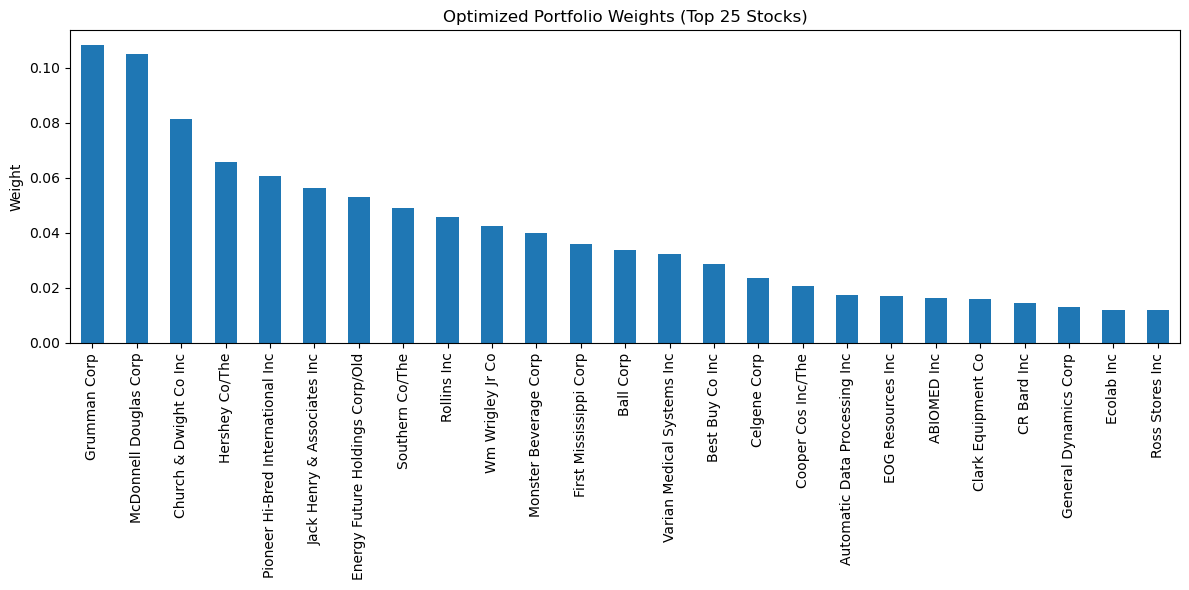

Markowitz Optimal Portfolio (Top 25 assets):
Expected Annual Return: 0.1547
Annual Volatility: 0.0775
Sharpe Ratio: 1.9963


In [23]:
# --- Data Preparation ---
df_sp_m_new.iloc[:, 0] = pd.to_datetime(df_sp_m_new.iloc[:, 0])
df_sp_m_new.set_index(df_sp_m_new.columns[0], inplace=True)
df_sp_m_new = df_sp_m_new.dropna(axis=1, how='any')
monthly_returns = df_sp_m_new.pct_change().dropna()

# Filter: Keep only stocks with positive average returns
avg_returns = monthly_returns.mean()
monthly_returns = monthly_returns.loc[:, avg_returns > 0]

# --- Compute Annualized Returns & Covariance ---
mean_returns = monthly_returns.mean() * 12
cov_matrix = monthly_returns.cov() * 12
# Add a tiny value to diagonal (1e-6) to ensure matrix is Positive Semi-Definite (PSD), 
# which is a mathematical requirement for optimization
dim = cov_matrix.shape[0]
cov_matrix_psd = cov_matrix + np.eye(dim) * 1e-6

tickers = monthly_returns.columns
n = len(tickers)

# --- cvxpy Variables (without boolean) ---
w = cp.Variable(n)

# --- Objective Function (Mean - Risk Aversion × Variance) ---
risk_aversion = 10
objective = cp.Maximize(mean_returns.values @ w - risk_aversion * cp.quad_form(w, cov_matrix_psd.values))

# --- Constraints ---
constraints = [
    cp.sum(w) == 1,
    w >= 0,
]

# --- Solve the Problem ---
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.OSQP, verbose=True)

# --- Get weights and manually select top 25 ---
weights = pd.Series(w.value, index=tickers)
top_25 = weights.nlargest(25)

# Re-normalize weights to sum to 1
top_25 /= top_25.sum()

# --- Output expected returns for selected assets ---
opt_expected_returns = mean_returns[top_25.index]

# --- Combine into DataFrame ---
opt_portfolio = pd.DataFrame({
    "Weight": top_25,
    "Expected Return": opt_expected_returns
}).sort_values(by="Weight", ascending=False)

# --- Display Results ---
print("\nOptimized Markowitz Portfolio (Top 25 Stocks):")
print(opt_portfolio)

# --- Plot ---
opt_portfolio["Weight"].plot(kind='bar', figsize=(12, 6), title='Optimized Portfolio Weights (Top 25 Stocks)')
plt.ylabel("Weight")
plt.tight_layout()
plt.show()

# --- Portfolio Performance ---
final_weights = top_25.values
mean_selected = mean_returns[top_25.index].values
cov_selected = cov_matrix.loc[top_25.index, top_25.index].values

# Expected return
port_return = np.dot(final_weights, mean_selected)

# Volatility
port_vol = np.sqrt(np.dot(final_weights.T, np.dot(cov_selected, final_weights)))

# Sharpe ratio (risk-free rate = 0)
sharpe_ratio = port_return / port_vol

# --- Print results ---
print("Markowitz Optimal Portfolio (Top 25 assets):")
print(f"Expected Annual Return: {port_return:.4f}")
print(f"Annual Volatility: {port_vol:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


Maximum Drawdown: -13.08%


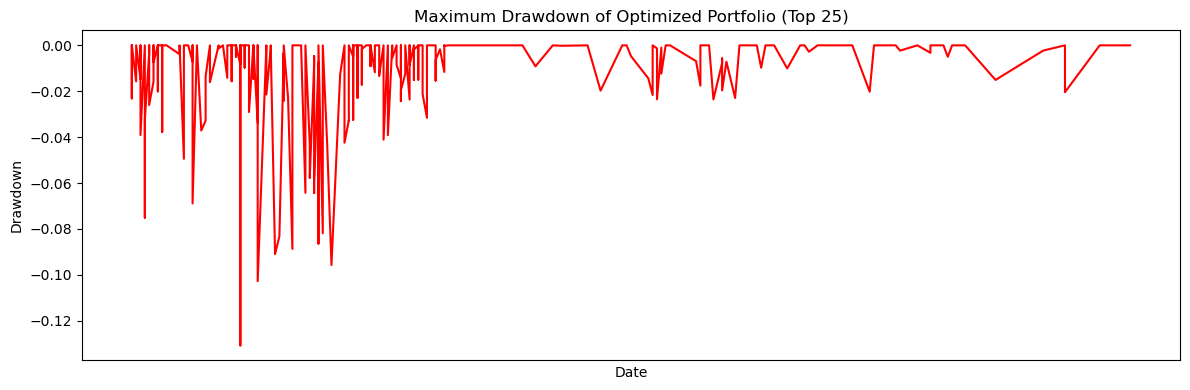

In [24]:
# --- Calculate Time Series of Portfolio Returns ---

# Get historical monthly returns for the selected assets
selected_returns = monthly_returns[top_25.index]

# Compute portfolio monthly returns using the optimized weights
portfolio_returns = selected_returns @ final_weights

# Convert to cumulative return series (starting from 1)
cumulative_returns = (1 + portfolio_returns).cumprod()

# Compute running maximum
running_max = cumulative_returns.cummax()

# Compute drawdown
drawdown = (cumulative_returns - running_max) / running_max

# Maximum drawdown
max_drawdown = drawdown.min()

print(f"Maximum Drawdown: {max_drawdown:.2%}")

# --- Plot Drawdown ---
plt.figure(figsize=(12, 4))
drawdown.plot(color='red', title='Maximum Drawdown of Optimized Portfolio (Top 25)')
plt.ylabel("Drawdown")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


Additionally we compute the efficient frontier, which shows the best possible trade-offs between risk (volatility) and expected return. Any portfolio on the frontier is efficient: for a given level of risk, it delivers the maximum expected return, and for a given return, it has the minimum possible risk. Only those collocated below the frontier are suboptimal— a better return for the same risk or lower risk for the same return can be found.


This placement of the optimal mean-variance portfolio that has been created in the upper right side of the efficient frontier makes sense because:
- Its return (~15.5%) is close to the upper end of the frontier’s return range (~18.6% max).
- Its risk (~7.75%) is also near the upper end of the frontier’s risk range (~8.96% max).

So it lies near the high-return, high-risk region, as expected from a Markowitz optimization with a moderate risk aversion (risk_aversion=10).

Notably the _target_returns_ value will always be 20% higher than the portfolio’s expected return, as it sets the upper bound for the efficient frontier, not only to ensure the computed curve stays focused around realistic targets but to avoid unnecessarily computing for extremely high (and often infeasible) returns as well.

In [22]:
# Restrict target returns range to reasonable upper bound (e.g., 1.2 × portfolio return)
target_returns = np.linspace(mean_returns.min(), port_return * 1.2, 50)
risks = []
weights_list = []

for target in target_returns:
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, cov_matrix_psd.values))
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        mean_returns.values @ w >= target - 1e-4  # small tolerance to improve feasibility
    ]
    prob = cp.Problem(objective, constraints)
    try:
        prob.solve(solver=cp.ECOS, verbose=False)
        if w.value is not None and prob.status == cp.OPTIMAL:
            risks.append(np.sqrt(w.value.T @ cov_matrix_psd.values @ w.value))
            weights_list.append(w.value)
        else:
            risks.append(np.nan)
            weights_list.append(None)
    except:
        risks.append(np.nan)
        weights_list.append(None)

# Filter out nan values for plotting
valid_idx = ~np.isnan(risks)
risks = np.array(risks)[valid_idx]
target_returns = target_returns[valid_idx]

# Plot efficient frontier zoomed in with portfolio point
plt.figure(figsize=(10,6))
plt.plot(risks, target_returns, 'b-', lw=2, label='Efficient Frontier')
plt.scatter(port_vol, port_return, color='r', marker='*', s=200, label='Selected Portfolio')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Expected Return')
plt.title('Efficient Frontier (Zoomed)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Portfolio return: {port_return:.4f}, risk: {port_vol:.4f}")
print(f"Efficient frontier return range: {target_returns.min():.4f} - {target_returns.max():.4f}")
print(f"Efficient frontier risk range: {risks.min():.4f} - {risks.max():.4f}")


ValueError: Incompatible dimensions (1, 711) (712, 1)

### Assessing momentum strategy-based portfolio performance

After computing the monthly and annual returns for each ticker in the momentum portfolio performance metrics are computed, namely expected annual returns, volatility and Sharpe ratio.

In [13]:
# Ensure datetime and index
df = df_sp_d_new.copy()
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
df.set_index(df.columns[0], inplace=True)
df = df.sort_index()

# Step 1: Get list of top 10 momentum tickers
momentum_tickers = top10['titolo'].tolist()

# Step 2: Extract only those columns
df_top10 = df[momentum_tickers]

# Step 3: Resample to monthly frequency using last trading day of each month
df_top10_monthly = df_top10.resample('M').last()

# Step 4: Compute monthly returns
monthly_returns_top10 = df_top10_monthly.pct_change().dropna()

# (Optional) Show the result
print(monthly_returns_top10.head())


            Chipotle Mexican Grill Inc  CME Group Inc  \
Dates                                                   
2006-03-31                    0.214693       0.051457   
2006-04-30                   -0.057772       0.023464   
2006-05-31                    0.106917      -0.036463   
2006-06-30                    0.055046       0.112962   
2006-07-31                   -0.138638      -0.060979   

            Automatic Data Processing Inc  Booking Holdings Inc  \
Dates                                                             
2006-03-31                      -0.011042              0.011813   
2006-04-30                      -0.035026             -0.016103   
2006-05-31                       0.031533              0.272504   
2006-06-30                      -0.002637             -0.039871   
2006-07-31                      -0.035060             -0.099799   

            Intuitive Surgical Inc  Marriott International Inc/MD  \
Dates                                                        

In [14]:
# Step 1: Get the ticker list
momentum_tickers = top10['titolo'].tolist()

# Step 2: Equal weights for the portfolio stocks
momentum_weights = np.array([1 / len(momentum_tickers)] * len(momentum_tickers))

# Step 3: Compute monthly returns for the momentum portfolio
momentum_returns = monthly_returns_top10[momentum_tickers]

momentum_portfolio_series = pd.Series(
    momentum_returns.values @ momentum_weights,
    index=momentum_returns.index,
    name='momentum'
)

# Step 4: Compute annualized performance metrics
momentum_return = momentum_portfolio_series.mean() * 12
momentum_volatility = momentum_portfolio_series.std() * np.sqrt(12)
momentum_sharpe = momentum_return / momentum_volatility

# Output
print("\nMomentum Portfolio performance on the whole period (1990-2018):")
print(f"Expected Annual Return: {momentum_return:.4f}")
print(f"Annual Volatility: {momentum_volatility:.4f}")
print(f"Sharpe Ratio: {momentum_sharpe:.4f}")



Momentum Portfolio performance on the whole period (1990-2018):
Expected Annual Return: 0.2457
Annual Volatility: 0.2668
Sharpe Ratio: 0.9209


Afterwards we compute the same metrics for the mean-variance portfolio but this time with equal weights and considering only the last 12 months to have better understanding of how it compares to the momentum stategy-based one.

In [ ]:
#Set index as DateTime index
df_sp_m_new[df_sp_m_new.columns[0]] = pd.to_datetime(df_sp_m_new[df_sp_m_new.columns[0]])
df_sp_m_new.set_index(df_sp_m_new.columns[0], inplace=True)

# Compute simple monthly returns
monthly_returns = df_sp_m_new.pct_change().dropna()

# COnsider only the last 12 mesi with .last()
end_date = monthly_returns.index.max()
start_date = end_date - pd.DateOffset(months=12)

last_12_months = monthly_returns.loc[(monthly_returns.index > start_date) & (monthly_returns.index <= end_date)]

# As before 
n_tickers = last_12_months.shape[1]
weights = np.array([1 / n_tickers] * n_tickers)

portfolio_returns = last_12_months.values @ weights
portfolio_returns = pd.Series(portfolio_returns, index=last_12_months.index)

expected_annual_return = portfolio_returns.mean() * 12
annual_volatility = portfolio_returns.std() * np.sqrt(12)
sharpe_ratio = expected_annual_return / annual_volatility

print("Mean-variance last 12 months (equal-weight S&P500):")
print(f"Expected Annual Return: {expected_annual_return:.4f}")
print(f"Annual Volatility: {annual_volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Mean-variance last 12 months (equal-weight S&P500):
Expected Annual Return: 0.1486
Annual Volatility: 0.1861
Sharpe Ratio: 0.7985


C:\Users\lucre\AppData\Local\Temp\ipykernel_15744\1047688881.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp_m_new[df_sp_m_new.columns[0]] = pd.to_datetime(df_sp_m_new[df_sp_m_new.columns[0]])
C:\Users\lucre\AppData\Local\Temp\ipykernel_15744\1047688881.py:13: UserWarning: Discarding nonzero nanoseconds in conversion.
  start_date = end_date - pd.DateOffset(months=12)


In [18]:
momentum_tickers = top10['titolo'].tolist()

# Step 2: Equal weights for momentum portfolio
momentum_weights = np.array([1 / len(momentum_tickers)] * len(momentum_tickers))

# Step 3: Calculate simple monthly returns for the entire period
monthly_returns = df_sp_m_new.pct_change().dropna()

# Filter only momentum tickers present in the data
momentum_tickers_filtered = [t for t in momentum_tickers if t in monthly_returns.columns]
momentum_returns = monthly_returns[momentum_tickers_filtered]

# --- NEW: Filter returns to last 12 months ---
end_date = momentum_returns.index.max()
start_date = end_date - pd.DateOffset(months=12)
momentum_returns_last12 = momentum_returns.loc[(momentum_returns.index > start_date) & (momentum_returns.index <= end_date)]

# Step 4: Compute monthly portfolio returns for last 12 months
momentum_portfolio_series = pd.Series(
    momentum_returns_last12.values @ momentum_weights[:len(momentum_tickers_filtered)],
    index=momentum_returns_last12.index,
    name='momentum'
)

# Step 5: Compute annualized metrics for last 12 months
momentum_return = momentum_portfolio_series.mean() * 12
momentum_volatility = momentum_portfolio_series.std() * np.sqrt(12)
momentum_sharpe = momentum_return / momentum_volatility

# Output
print("\nMomentum Portfolio (Last 12 Months):")
print(f"Expected Annual Return: {momentum_return:.4f}")
print(f"Annual Volatility: {momentum_volatility:.4f}")
print(f"Sharpe Ratio: {momentum_sharpe:.4f}")



Momentum Portfolio (Last 12 Months):
Expected Annual Return: 0.3051
Annual Volatility: 0.2801
Sharpe Ratio: 1.0891


Since the measures we choose should also be calculated for the index representing the chosen securities universe, we compute the optimal portfolio taking into account all the tickers in the S&P500 with no exclusions. Then we compute the same metrics as before so see how it compares to the other portfolios.

Markowitz Optimal Portfolio:
Expected Annual Return: 0.1126
Annual Volatility: 0.0507
Sharpe Ratio: 2.2195

Selected Stock Weights (> 1%):
Grumman Corp                         0.096648
CBS Broadcasting Inc                 0.078798
McDonnell Douglas Corp               0.067124
Cross & Trecker Corp                 0.054705
Church & Dwight Co Inc               0.043024
Florida Progress Corp                0.041354
First Mississippi Corp               0.040196
Pioneer Hi-Bred International Inc    0.038618
Energy Future Holdings Corp/Old      0.035673
Blockbuster Entertainment Corp       0.032872
Hershey Co/The                       0.032146
USLIFE Corp                          0.028984
Rollins Inc                          0.027546
Southern Co/The                      0.026742
Gerber Products Co                   0.025571
Paramount Communications Inc         0.019594
Monster Beverage Corp                0.019049
Hormel Foods Corp                    0.018106
Jack Henry & Associates Inc      

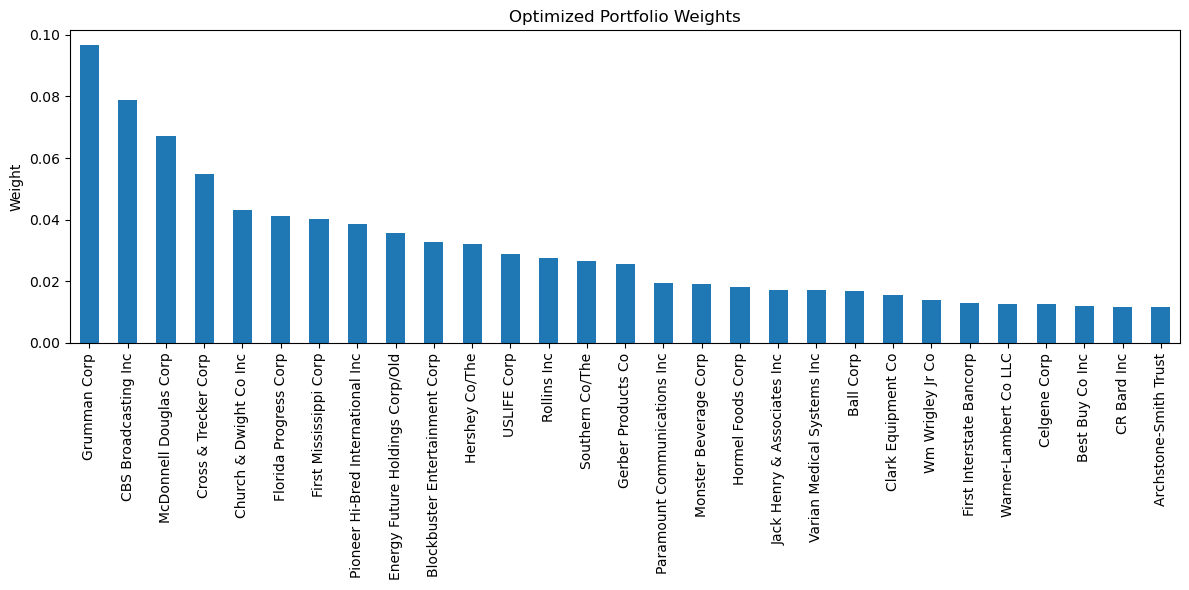

Maximum Drawdown: -7.46%


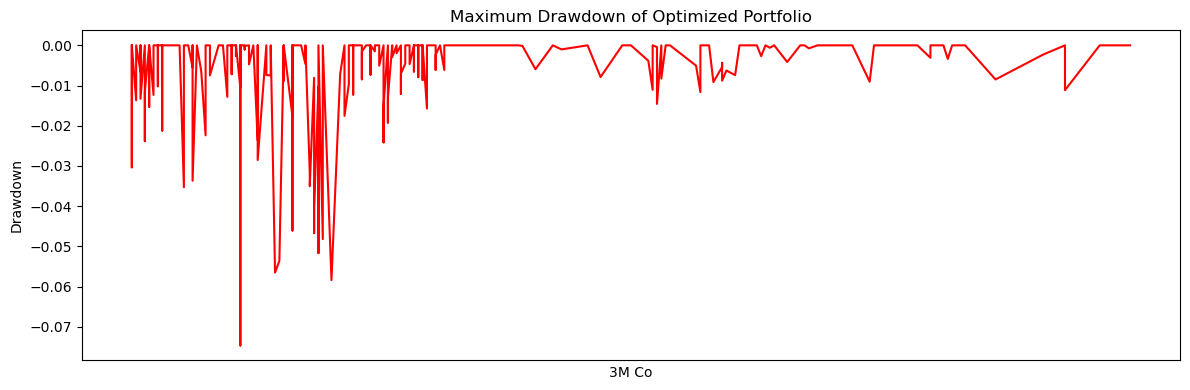

In [20]:
# --- Step 1: Preprocessing dataframe ---

# Copia per sicurezza
df = df_sp_m_new.copy()

# Converto prima colonna in datetime
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])

# Imposto la prima colonna come indice
df.set_index(df.columns[0], inplace=True)

# Rimuovo colonne con valori NaN (se ci sono)
df.dropna(axis=1, how='any', inplace=True)

# --- Step 2: Calcolo rendimenti mensili semplici ---
monthly_returns = df.pct_change().dropna()

# --- Step 3: Filtra titoli con rendimento medio positivo ---
avg_returns = monthly_returns.mean()
monthly_returns = monthly_returns.loc[:, avg_returns > 0]

# --- Step 4: Calcolo medie e covarianza ---
mean_returns = monthly_returns.mean()
cov_matrix = monthly_returns.cov()

# --- Step 5: Funzioni per calcolare statistiche portafoglio ---
def portfolio_stats(weights):
    port_return = np.dot(weights, mean_returns) * 12  # annualizzato
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12, weights)))  # annualizzato
    sharpe = port_return / port_vol
    return port_return, port_vol, sharpe

def neg_sharpe_ratio(weights):
    return -portfolio_stats(weights)[2]

# --- Step 6: Constraints e bounds ---
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(monthly_returns.columns)))

# --- Step 7: Inizializzo pesi uguali ---
initial_weights = np.array([1 / len(monthly_returns.columns)] * len(monthly_returns.columns))

# --- Step 8: Ottimizzazione ---
opt_result = minimize(neg_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# --- Step 9: Risultati ---
opt_weights = opt_result.x
port_return, port_vol, sharpe_ratio = portfolio_stats(opt_weights)

print("Markowitz Optimal Portfolio:")
print(f"Expected Annual Return: {port_return:.4f}")
print(f"Annual Volatility: {port_vol:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

# Pesi > 1%
opt_portfolio = pd.Series(opt_weights, index=monthly_returns.columns)
opt_portfolio = opt_portfolio[opt_portfolio > 0.01].sort_values(ascending=False)

print("\nSelected Stock Weights (> 1%):")
print(opt_portfolio)

# --- Step 10: Plot ---
opt_portfolio.plot(kind='bar', figsize=(12, 6), title='Optimized Portfolio Weights')
plt.ylabel("Weight")
plt.tight_layout()
plt.show()
# --- Step 11: Calculate Maximum Drawdown ---

# Calculate portfolio returns from optimized weights
weighted_returns = (monthly_returns * opt_weights).sum(axis=1)

# Cumulative returns (assuming initial investment of 1)
cumulative_returns = (1 + weighted_returns).cumprod()

# Calculate running max
running_max = cumulative_returns.cummax()

# Calculate drawdown
drawdown = (cumulative_returns - running_max) / running_max

# Calculate max drawdown
max_drawdown = drawdown.min()

print(f"Maximum Drawdown: {max_drawdown:.2%}")

# Optional: Plot drawdown
plt.figure(figsize=(12, 4))
drawdown.plot(title='Maximum Drawdown of Optimized Portfolio', color='red')
plt.ylabel('Drawdown')
plt.tight_layout()
plt.show()


In [21]:
# Copy dataframe
df = df_sp_m_new.copy()

# Convert the first column to datetime and set it as the index
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
df.set_index(df.columns[0], inplace=True)

# Remove columns with any NaN values (if any)
df.dropna(axis=1, how='any', inplace=True)

# Calculate simple monthly returns
monthly_returns = df.pct_change().dropna()

# Number of tickers
n_tickers = monthly_returns.shape[1]

# Equal weights for each ticker
weights = np.array([1 / n_tickers] * n_tickers)

# Calculate monthly portfolio returns
portfolio_returns = monthly_returns.values @ weights

# Create a Series for convenience
portfolio_returns = pd.Series(portfolio_returns, index=monthly_returns.index)

# Calculate annualized metrics (12 months)
expected_annual_return = portfolio_returns.mean() * 12
annual_volatility = portfolio_returns.std() * np.sqrt(12)
sharpe_ratio = expected_annual_return / annual_volatility

print("Equal-weight S&P500 Portfolio (1990-2018):")
print(f"Expected Annual Return: {expected_annual_return:.4f}")
print(f"Annual Volatility: {annual_volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


Equal-weight S&P500 Portfolio (1990-2018):
Expected Annual Return: 0.1486
Annual Volatility: 0.1859
Sharpe Ratio: 0.7991


### Drawdown

The drawdown is a measure of decline from a historical peak in the value of an investment or portfolio representing the percentage loss experienced from the highest value reached before a downturn. It is considered as a valuable metric to use as it helps investors understand the risk of a strategy by quantifying the potential loss over a period.


Given a time series of portfolio values (or cumulative returns) \( V_t \), the drawdown at time \( t \) is:

$$
DD_t = \frac{V_t - P_t}{P_t} = \frac{V_t}{P_t} - 1
$$

where:

- \(V_t\) is the portfolio value at time \(t\).
- (P_t = \max_{s \leq t} V_s\) is the running maximum portfolio value up to time \(t\).

---

- When the portfolio value reaches a new peak, the drawdown is zero.
- When the portfolio value drops below the previous peak, the drawdown is negative, representing a loss.
- The **maximum drawdown** (Max DD) over a period is the largest drawdown observed:

$$
\text{Max Drawdown} = \min_t DD_t
$$


In [52]:
# Momentum drawdown
cumulative_returns = (1 + momentum_portfolio_series).cumprod()

running_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - running_max) / running_max

max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")



Maximum Drawdown: -6.55%


In [11]:
# Sharp ratio portfolio
cumulative_returns = (1 + portfolio_returns).cumprod()

running_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - running_max) / running_max

max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")


Maximum Drawdown: -33.38%


### Rebalancing the momentum investing stategy portfolio

Rebalancing the portfolio is crucial as momentum changes over time: stocks that showed strong momentum last month may lose it in the following months. Rebalancing regularly (we chose to rebalance monthly) ensures the portfolio holds the current top momentum stocks, rather than outdated ones. 
It ensures it continuously adapts to market conditions by holding the most promising stocks according to recent momentum signals. It is essential to maintain the effectiveness and risk profile of the momentum strategy.

In [54]:
# 1. Resample daily prices to monthly (last trading day of each month)
df_sp_d_new.iloc[:, 0] = pd.to_datetime(df_sp_d_new.iloc[:, 0])  # Convert first column to datetime
df_sp_d_new.set_index(df_sp_d_new.columns[0], inplace=True)      # Set as index

monthly_prices = df_sp_d_new.resample('M').last()

# 2. Define function to calculate momentum (12-month return, skip last month)
def calculate_momentum(prices, lookback=12, skip=1):
    return prices.shift(skip).pct_change(lookback)

# 3. Parameters
top_n = 10
momentum_window = 12
skip_last_month = 1
rebalance_dates = monthly_prices.index

# 4. Store monthly portfolio returns
portfolio_returns = []

# 5. Rebalance each month
for i in range(momentum_window + skip_last_month, len(monthly_prices) - 1):
    # Current date and next date
    current_date = rebalance_dates[i]
    next_date = rebalance_dates[i + 1]

    # Slice momentum calculation window
    momentum_df = calculate_momentum(monthly_prices.iloc[:i+1], 
                                     lookback=momentum_window, 
                                     skip=skip_last_month)
    
    # Get momentum values for current rebalance date
    momentum_values = momentum_df.loc[current_date].dropna()

    # Select top N stocks
    top_stocks = momentum_values.sort_values(ascending=False).head(top_n).index.tolist()

    # Equal weights
    weights = np.array([1 / top_n] * top_n)

    # Calculate portfolio return from current_date to next_date
    prices_now = monthly_prices.loc[current_date, top_stocks]
    prices_next = monthly_prices.loc[next_date, top_stocks]
    returns = (prices_next - prices_now) / prices_now

    portfolio_return = np.dot(weights, returns)
    portfolio_returns.append((next_date, portfolio_return))

# 6. Convert to DataFrame
momentum_portfolio_series = pd.Series(
    data=[ret for _, ret in portfolio_returns],
    index=[date for date, _ in portfolio_returns],
    name='MomentumPortfolio'
)


C:\Users\lucre\AppData\Local\Temp\ipykernel_15744\1659266739.py:9: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return prices.shift(skip).pct_change(lookback)
C:\Users\lucre\AppData\Local\Temp\ipykernel_15744\1659266739.py:9: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return prices.shift(skip).pct_change(lookback)
C:\Users\lucre\AppData\Local\Temp\ipykernel_15744\1659266739.py:9: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill

At last the cumulative return curve is plotted, visually showing portfolio growth over time when rebalancing each month.

Maximum Drawdown: -61.19%


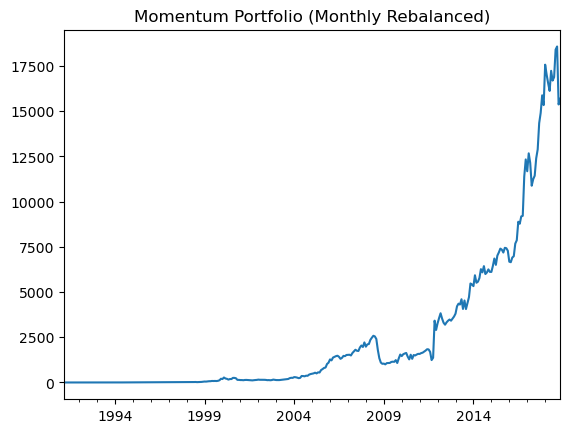

In [55]:
cumulative_returns = (1 + momentum_portfolio_series).cumprod()
cumulative_returns.plot(title="Momentum Portfolio (Monthly Rebalanced)")

# Drawdown
running_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - running_max) / running_max
max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")

